In [18]:
import numpy as np
import os
import pywren_ibm_cloud as pywren
import pickle
import pi_montecarlo_plot
import matplotlib.pyplot as plt
import pika
%matplotlib notebook

In [19]:
n_functs = 1000
loop_per_funct = 10000
iter_send_point = 10000
rabbitmq_url = '<RABBITMQ_URL>'
rabbitmq_queue = 'pi_montecarlo'

In [20]:
def pi_montecarlo(n, rabbitmq):
    channel = rabbitmq.channel()
    channel.queue_declare(queue=rabbitmq_queue)
    
    value = 0
    for i in range(loop_per_funct):
        x = np.random.rand() # Generate random point between 0 and 1
        y = np.random.rand()
        z = np.sqrt(x * x + y * y)
        if z <= 1: # Point is inside circle
            value += 1
        if (i % iter_send_point == 0): # Send generated point
            body = pickle.dumps((x, y, z))
            channel.basic_publish(exchange='', routing_key='pi_montecarlo', body=body)
            
    est_pi = float(value) * 4 / loop_per_funct
    return est_pi

def mean(results):
    return np.mean(results)

In [21]:
pwex = pywren.ibm_cf_executor(runtime_memory=256, rabbitmq_monitor=True)
map_iterdata=range(n_functs)
futures = pwex.map_reduce(pi_montecarlo, map_iterdata, mean)

PyWren v1.0.21-SNAPSHOT init for IBM Cloud Functions - Namespace: aitor.a98@gmail.com_dev - Region: eu_gb
ExecutorID 904b-46e7 | JobID M000 - Selected Runtime: ibmfunctions/action-python-v3.7 - 256MB 
ExecutorID 904b-46e7 | JobID M000 - Uploading function and data - Total: 22.2KiB
ExecutorID 904b-46e7 | JobID M000 - Starting function invocation: pi_montecarlo()  - Total: 1000 activations
ExecutorID 904b-46e7 | JobID R000 - Selected Runtime: ibmfunctions/action-python-v3.7 - 256MB 
ExecutorID 904b-46e7 | JobID R000 - Uploading function and data - Total: 356.2KiB
ExecutorID 904b-46e7 | JobID R000 - Starting function invocation: mean()  - Total: 1 activations


<IPython.core.display.Javascript object>


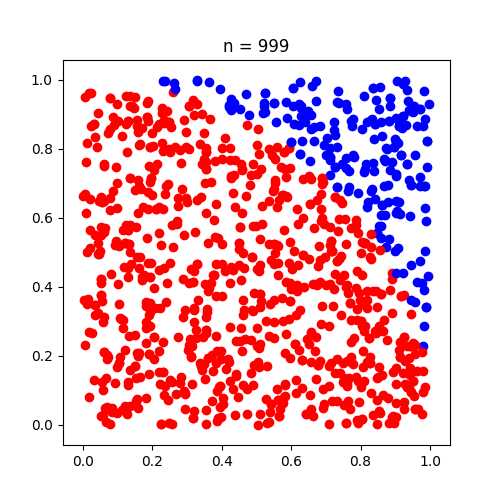

In [22]:
fig, ax = plt.subplots(figsize=(5,5))
plt.ion()
fig.canvas.draw()

params = pika.URLParameters(rabbitmq_url)
connection = pika.BlockingConnection(params)
channel = connection.channel()
channel.queue_declare(queue=rabbitmq_queue)

class callback():
    def __init__(self):
        self.n_messages = 0
    
    def __call__(self, ch, method, properties, body):
        x, y, z = pickle.loads(body)
        color = 'red' if z <= 1 else 'blue'
        ax.scatter(x, y, c=color)
        plt.title("n = {}".format(self.n_messages))
        fig.canvas.draw()
        self.n_messages += 1
        if self.n_messages >= ((loop_per_funct // iter_send_point) * n_functs):
            ch.stop_consuming()
        

channel.basic_consume(callback(), queue='pi_montecarlo')
channel.start_consuming()
channel.queue_delete(queue=rabbitmq_queue)
connection.close()
plt.show()

In [23]:
pi = pwex.get_result(futures=futures)
print('Estimated pi: {}'.format(pi))
pwex.clean()

ExecutorID 904b-46e7 - Getting results...



Estimated pi: 3.1422556000000004
ExecutorID 904b-46e7 - Cleaning temporary data
